In [1]:
!pip install -q tensorflow-hub
!pip install -q gensim
!pip install -q sklearn
!pip install -q matplotlib
!apt-get install -qq jq
!wget -nc -c https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec

Selecting previously unselected package libonig4:amd64.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libonig4_6.7.0-1_amd64.deb ...
Unpacking libonig4:amd64 (6.7.0-1) ...
Selecting previously unselected package libjq1:amd64.
Preparing to unpack .../libjq1_1.5+dfsg-2_amd64.deb ...
Unpacking libjq1:amd64 (1.5+dfsg-2) ...
Selecting previously unselected package jq.
Preparing to unpack .../jq_1.5+dfsg-2_amd64.deb ...
Unpacking jq (1.5+dfsg-2) ...
Setting up libonig4:amd64 (6.7.0-1) ...
Setting up libjq1:amd64 (1.5+dfsg-2) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up jq (1.5+dfsg-2) ...
--2018-12-16 23:15:35--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.105
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.105|:443... connected.
HTTP re

Download and unpack the annotations from the 2014 MSCOCO dataset. This has 100k+ human-entered image captions. Each is a short declarative sentence. 

This dataset has shallow linguistic depth but a lot of vocabulary.

**jq** is a super-fast streaming JSON parser app.

In [0]:
!wget -c -nc -q http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -p annotations_trainval2014.zip annotations/captions_train2014.json > captions_train2014.json
!jq -r '.annotations[]|.caption' < captions_train2014.json > sentences.txt

In [3]:
import pickle
import os
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
from sklearn.decomposition import PCA
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
from nltk. corpus import gutenberg
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from gensim.models import KeyedVectors
from gensim.models import FastText
from keras.layers import Input, Dense, Lambda, Layer
from keras.optimizers import Adam, Nadam
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download('reuters')
nltk.download('gutenberg')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

# Preprocessing Text

The preprocessing code is data specific.  
  
It is an example of how one can use a pre-trained word2vec to embed sentences into a vector space.

In [4]:
# A little tight on RAM, so parse word2vec, save object to disk, memory-map object back into RAM.
# Now the OS can drop the space whenever it is not being read.
w2v = None
if not os.path.exists('/content/wiki.en.vec.kv'):
    print('Read word2vec vectors from text')
    w2v = KeyedVectors.load_word2vec_format('/content/wiki.en.vec')
    print('Save word2vec vectors to cache')
    w2v.save('/content/wiki.en.vec.kv')
else:
    print('Using cached word2vec vectors')
    w2v = KeyedVectors.load('/content/wiki.en.vec.kv', mmap='r')
embedding_size = len(w2v['and'])
embedding_size

Read word2vec vectors from text
Save word2vec vectors to cache


300

In [5]:
!ls -ld /content
!ls -l /content

drwxr-xr-x 1 root root 4096 Dec 16 23:33 /content
total 9865704
-rw-r--r-- 1 root root  252872794 Jul 10 17:58 annotations_trainval2014.zip
-rw-r--r-- 1 root root   66782097 Dec 16 23:20 captions_train2014.json
drwxr-xr-x 1 root root       4096 Dec 10 17:34 sample_data
-rw-r--r-- 1 root root   22159544 Dec 16 23:21 sentences.txt
-rw-r--r-- 1 root root 6597238061 May  2  2017 wiki.en.vec
-rw-r--r-- 1 root root  140148778 Dec 16 23:33 wiki.en.vec.kv
-rw-r--r-- 1 root root 3023244128 Dec 16 23:33 wiki.en.vec.kv.vectors.npy


In [0]:
def token_sent (text):
    #strg = ''
    #for word in text:
    #    strg += word
    #    strg += ' '
    strg_cleaned = text.lower()
    for x in ['\xd5d','\n','"',"!", '#','$','%','&','(',')','*','+',',','-','/',':',';','<','=','>','?','@','[','^',']','_','`','{','|','}','~','\t']:
        strg_cleaned = strg_cleaned.replace(x, '')
    sentences = sent_tokenize(strg_cleaned)
    return sentences

def split_into_sent (text):
    strg = ''
    for word in text:
        strg += word
        strg += ' '
    strg_cleaned = strg.lower()
    for x in ['\xd5d','\n','"',"!", '#','$','%','&','(',')','*','+',',','-','/',':',';','<','=','>','?','@','[','^',']','_','`','{','|','}','~','\t']:
        strg_cleaned = strg_cleaned.replace(x, '')
    sentences = sent_tokenize(strg_cleaned)
    return sentences

In [0]:
maxindex = -1
def vectorize_sentences(sentences):
    vectorized = []
    for sentence in sentences:
        if sentence[-1] == '.':
            sentence = sentence[:-1]
        byword = sentence.split()
        concat_vector = []
        for word in byword:
            #print(word)
            try:
                concat_vector.append(w2v[word])
            except:
                #print('fail on {}'.format(word))
                pass
        vectorized.append(concat_vector)
    return vectorized

def wordify(sentence):
    if sentence[-1] == '.':
        sentence = sentence[:-1]
    byword = sentence.split()
    for word in byword:
        if not word in w2v:
            return None
    return byword

def vectorize_sentence(sentence):
    vector = []
    for word in sentence:
        vector.append(w2v[word])
    return vector
        

Preprocessing text from a variety of different sources.

It's important to shuffle the text vectors before splitting them into test and train samples.   
  
This is done to avoid clumping text with similar context and style in the dataset because it can confuse the neural network during training.load_word2vec_format

In [8]:
# cache [['word', 'word',...'word']]
# in generator, look them up
data_concat = []
#!rm -f /content/10words.pk
if not os.path.exists('/content/10words.pk'):
    data_concat = []
    total = 0
    found = 0
    with open('sentences.txt', 'r') as f:
        for line in f:
            total += 1
            if total % 20000 == 0:
                print(total)
            #if len(data_concat) > 10000:
            #    break
            line = line.strip()
            if line.count(' ') != 9:
                continue
            text_array = token_sent(line)
            for sentence in text_array:
                #print(sentence)
                vect = wordify(sentence)
                if vect != None and len(vect) == 10:
                    data_concat.append(vect)
                    #print(vect)

#    total = 0
#    found = 0
#    for t in []: # [brown.words(), reuters.words(), gutenberg.words()]:
#       text = split_into_sent(t)
#        total += len(vect)
#        vect = collect_sentences(text)
#       data = [x for x in vect if len(x) == 10]
#        for x in data:
#            found += 1
#            data_concat.append(list(itertools.chain.from_iterable(x)))
    with open('/content/10words.pk', 'wb') as f:
        pickle.dump(data_concat, f)
else:
    with open('/content/10words.pk', 'rb') as f:
        data_concat = pickle.load(f)
print('Total # of 10-word sentences: {}'.format(len(data_concat)))
print(data_concat[0])
print(data_concat[2])
!ls -sh /content

20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
Total # of 10-word sentences: 85806
['a', 'blue', 'and', 'white', 'bathroom', 'with', 'butterfly', 'themed', 'wall', 'tiles']
['the', 'vanity', 'contains', 'two', 'sinks', 'with', 'a', 'towel', 'for', 'each']
total 9.5G
 11M 10words.pk			    22M sentences.txt
242M annotations_trainval2014.zip  6.2G wiki.en.vec
 64M captions_train2014.json	   134M wiki.en.vec.kv
4.0K sample_data		   2.9G wiki.en.vec.kv.vectors.npy


In [0]:
train = data_concat[10000:]
test = data_concat[:10000]
np.random.shuffle(train)
np.random.shuffle(test)
train = np.array(train)
test = np.array(test)
#del data_concat

def vectorize_batch(sentences):
    batch_features = np.zeros((batch_size, embedding_size * len(sentences[0])))
    for i in range(batch_size):
         batch_features[i] = np.reshape(np.array(vectorize_sentence(sentences[i])), embedding_size * len(sentences[0]))
    return batch_features
            
#add randomization of batch
#model.fit_generator(generator(features, labels, batch_size), samples_per_epoch=50, nb_epoch=10
def generator(sentences, batch_size):
    index = 0
    while True:
        batch_features = np.zeros((batch_size, embedding_size * len(sentences[0])))
        for i in range(batch_size):
            batch_features[i] = np.reshape(np.array(vectorize_sentence(sentences[index + i])), embedding_size * len(sentences[0]))
        index += batch_size
        if index >= len(sentences):
            index = 0
        yield batch_features, batch_features
        

# Variational Autoencoder

In [10]:
batch_size = 500
original_dim = 3000
latent_dim = 1000
intermediate_dim = 1200
epochs=250
epsilon_std = 1.0
dist_weight = 1
kl_weight = 1# 0.001
learning_rate = 0.001
opt = Nadam(lr=learning_rate)


# Can only train on batch_size modulo data
train = train[:(len(train) // batch_size) * batch_size]
test = test[:(len(test) // batch_size) * batch_size]

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# placeholder loss
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
        
    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def vae_lossX(self, x, x_decoded_mean):
        #xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        xent_loss = metrics.logcosh(x, x_decoded_mean)
        kl_loss = K.mean(K.sum(- 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)))
        return K.mean(dist_weight * xent_loss + kl_weight * kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # we don't use this output, but it has to have the correct shape:
        return K.ones_like(x)

# separate break-out of 
def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kl_loss = kl_weight * kl_loss
    return kl_loss

loss_layer = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, [loss_layer])
vae.compile(optimizer='rmsprop', loss=[zero_loss], metrics=[kl_loss])
vae.summary()

#checkpoint
cp = [ModelCheckpoint(filepath="/content/model.h5", verbose=1, save_best_only=True)]

print('Training with {} training samples, {} test samples'.format(len(train), len(test)))
#train
if os.path.exists('/content/model.h5'):
    vae.load_weights('/content/model.h5')
    history = None
else:
    history = vae.fit_generator(generator(train, batch_size),
        shuffle=True,
        epochs=epochs,
        steps_per_epoch=len(train)/batch_size,
        validation_steps=len(test)/batch_size,
        verbose=2,
        validation_data=generator(test, batch_size), 
        callbacks=cp)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (500, 3000)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (500, 1200)          3601200     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (500, 1000)          1201000     dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (500, 1000)          1201000     dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## Plot the training curves

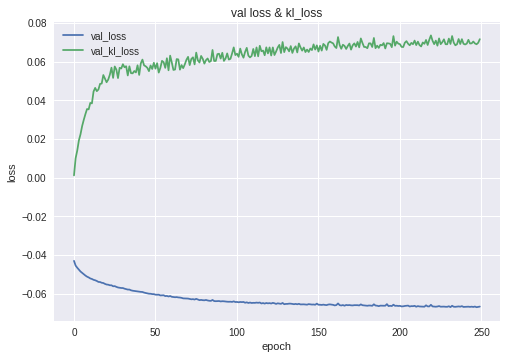

In [12]:
import sklearn.preprocessing as skprep 

if history != None:
    plt.plot(skprep.normalize([history.history['val_loss']])[0])
    plt.plot(skprep.normalize([history.history['val_kl_loss']])[0])
    plt.title('val loss & kl_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'val_kl_loss'], loc='upper left')
    plt.show()


# Generating Text From Latent Space

In [0]:
# some matrix magic
def sent_parse(sentence, mat_shape):
    data_concat = []
    word_vecs = vectorize_sentences(sentence)
    for x in word_vecs:
        data_concat.append(list(itertools.chain.from_iterable(x)))
    zero_matr = np.zeros(mat_shape)
    zero_matr[0] = np.array(data_concat)
    return zero_matr

In [0]:
# input: original dimension sentence vector
# output: text
def print_sentence_with_w2v(sent_vect):
    word_sent = ''
    tocut = sent_vect
    for i in range (int(len(sent_vect)/300)):
        word_sent += w2v.most_similar(positive=[tocut[:300]], topn=1)[0][0]
        word_sent += ' '
        tocut = tocut[300:]
    print(word_sent)

In [0]:
# input: encoded sentence vector
# output: encoded sentence vector in dataset with highest cosine similarity
def find_similar_encoding(sent_vect):
    all_cosine = []
    for sent in sent_encoded:
        result = 1 - spatial.distance.cosine(sent_vect, sent)
        all_cosine.append(result)
    data_array = np.array(all_cosine)
    maximum = data_array.argsort()[-3:][::-1][1]
    new_vec = sent_encoded[maximum]
    return new_vec

In [0]:
# input: two points, integer n
# output: n equidistant points on the line between the input points (inclusive)
def shortest_homology(point_one, point_two, num):
    dist_vec = point_two - point_one
    sample = np.linspace(0, 1, num, endpoint = True)
    hom_sample = []
    for s in sample:
        hom_sample.append(point_one + s * dist_vec)
    return hom_sample

In [0]:
# input: two written sentences, VAE batch-size, dimension of VAE input
# output: the function embeds the sentences in latent-space, and then prints their generated text representations
# along with the text representations of several points in between them
def sent_2_sent(sent1,sent2, batch, dim):
    a = sent_parse([sent1], (batch,dim))
    b = sent_parse([sent2], (batch,dim))
    encode_a = encoder.predict(a, batch_size = batch)
    encode_b = encoder.predict(b, batch_size = batch)
    test_hom = hom_shortest(encode_a[0], encode_b[0], 5)
    
    for point in test_hom:
        p = generator.predict(np.array([point]))[0]
        print_sentence(p)

Printing sentences from the training set and comparing them with the original will test whether the custom print function works properly.

In [18]:
print_sentence_with_w2v(train[1])
print_sentence_with_w2v(train[2])

The encoder takes the test set of sentence vectors (concatenanted word vectors) and embeds them into a lower dimensional vector space.

In [0]:
 
test_embedded = vectorize_batch(test)
test_encoded = encoder.predict(test_embedded, batch_size = 500)

The decoder takes the list of latent dimensional encodings from above and turns them back into vectors of their original dimension.

In [0]:
test_decoded = generator.predict(np.array(test_encoded), batch_size=500)

The encoder trained above embeds sentences (concatenated word vetors) into a lower dimensional space. The code below takes two of these lower dimensional sentence representations and finds five points between them. It then uses the trained decoder to project these five points into the higher, original, dimensional space. Finally, it reveals the text represented by the five generated sentence vectors by taking each word vector concatenated inside and finding the text associated with it in the word2vec used during preprocessing.

In [58]:
test_hom = shortest_homology(test_encoded[3], test_encoded[10], 5)
for point in test_hom:
    p = generator.predict(np.array([point]))[0]
    print_sentence_with_w2v(p)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


two men upstages with two motorcycles in an waterblasting picture 
two heartthrobs onlooking with two buggies in an slippingglimpse pencilwise 
a rubicks the with and handrails and an pebbledashing rotches 
a blue and white and doorways nestled by a rotomolded 
a green and white pebbledashing entryway entranceways by a sink 


The code below does the same thing, with one important difference. After sampling equidistant points in the latent space between two sentence embeddings, it finds the embeddings from our encoded dataset those points are most similar to. It then prints the text associated with those vectors.
  
This allows us to explore how the Variational Autoencoder clusters our dataset of sentences in latent space. It lets us investigate whether sentences with similar concepts or grammatical styles are represented in similar areas of the lower dimensional space.

In [0]:
test_hom = shortest_homology(test_encoded[2], test_encoded[400], 20)
for point in test_hom:
    p = generator.predict(np.array([find_similar_encoding(point)]))[0]
    print_sentence_with_w2v(p)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a woman with an umbrella is standing by the street 
a group of people riding on the pulling of horses 
a group of people riding on the pulling of horses 
a group of people riding on the pulling of horses 
a group of people riding on the pulling of horses 
a group of people riding on the pulling of horses 
a group of people riding on the pulling of horses 


# Visualization

## Plot Original and Variational embeddings
First, create a 2D visualization of the embedding space. Use Principal Components Analysis (PCA) to project N-dimensional space to 2 dimensions. PCA creates an n-dimensional rotation that optimizes for the largest standard deviation in column 0, second largest stdev in column 1, and so on. Using the first two columns as X and Y in a scatter plot gives a decent 2D representation of the embedding space.

In [0]:
pca_orig = PCA(n_components=2)
pca_orig.fit(test_embedded)
pca_predict = PCA(n_components=2)
pca_predict.fit(test_encoded)

## Create a small test set of similar sentences, and project via PCA.
These sentences are adapted from the famous "twisty maze of passages" from the very first text adventure game, "Adventure".

In [0]:
adventure = [
    'you are in a twisty little maze of passages now',
    'you are in a twisty maze of little passages now',
    'you are in a little twisty maze of passages now',
    'you are in a maze of little twisting passages now',
    'you are in a maze of little twisty passages now'
]
freestyle = [
    'before you is a twisty maze of passages all alike',
    'you see now a twisty maze of passages all like',
    'a maze of twisty passages all alike stretches before you',
    'a twisty maze all alike is in front of you',
    'twisty passages forming a maze stretch in front of you'
]
almost_adventure = [
    'you come upon a maze of twisty passages all alike'
]
adventure_more = [
    'you are in a maze of twisty little passages now',
    'you are in a little maze of twisting passages now',
    'you are in a maze of twisting little passages now',
    'you are in a little maze of twisty passages now',
    'you are in a twisting maze of little passages now',
    'you are in a twisting little maze of passages now',
]
    
def predict(sentences):
    embeds = []
    for v in vectorize_sentences(sentences):
        embeds.append(np.reshape(v, (3000)))
    orig = np.array(embeds)
    predicted = np.array(encoder.predict(orig, batch_size = 1))
    return (orig, predicted)

In [0]:

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Original')
ax2.set_title('VAE Latent')
(orig, predicted) = predict(adventure + adventure_more)
for xy in pca_orig.transform(orig):
    ax1.scatter(xy[0], xy[1], color='black')
for xy in pca_predict.transform(predicted):
    ax2.scatter(xy[0], xy[1], color='black')
(orig, predicted) = predict(freestyle)
for xy in pca_orig.transform(orig):
    ax1.scatter(xy[0], xy[1], color='blue')
for xy in pca_predict.transform(predicted):
    ax2.scatter(xy[0], xy[1], color='blue')
(orig, predicted) = predict(almost_adventure)
for xy in pca_orig.transform(orig):
    ax1.scatter(xy[0], xy[1], color='green')
for xy in pca_predict.transform(predicted):
    ax2.scatter(xy[0], xy[1], color='green')


## Heatmaps

In [0]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  corr = np.log(corr)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0.9999,
      vmax=1.0,
      cmap="YlOrRd"
  )

  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")



In [0]:
plot_similarity(adventure_maze, maze_orig, 90)

In [0]:
plot_similarity(adventure_maze, maze_predicted, 90)